# CNN Gender Classifier (VGG16 Architecture, CelebA)

## Imports

In [ ]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from PIL import Image

from io import BytesIO
import base64

plt.style.use('ggplot')
%matplotlib inline


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Dataset

### Import the Dataset

In [ ]:
#Connect to Drive if the data is from G-Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Specify the destination extraction folder
destination_folder = '/content'

# Extract the first file
shutil.unpack_archive(file1_path, destination_folder)

# Extract the second file
shutil.unpack_archive(file2_path, destination_folder)


### Preparing the Dataset

In [ ]:
df1 = pd.read_csv('list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [ ]:
df2 = pd.read_csv('list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [ ]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


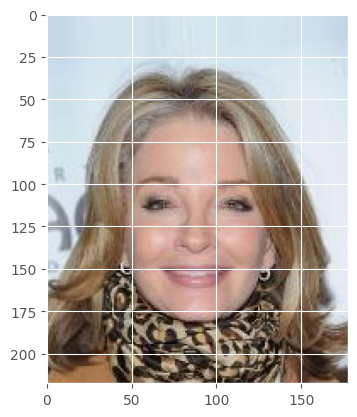

In [ ]:
img = Image.open('img_align_celeba/000018.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Implementing a Custom DataLoader Class

In [ ]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:


custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                      transforms.Resize((128, 128)),
                                      #transforms.RandomHorizontalFlip(),
                                      #transforms.RandomRotation(30),
                                      #transforms.Grayscale(num_output_channels=3),
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                      #transforms.GaussianBlur(5),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='img_align_celeba/',
                              transform=train_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='img_align_celeba/',
                             transform=custom_transform)

BATCH_SIZE=64*torch.cuda.device_count()


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device("cuda:0")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
Epoch: 2 | Batch index: 0 | Batch size: 64


## Model

In [ ]:
# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 5

# Architecture
num_features = 128*128
num_classes = 2

In [ ]:
class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_3 = nn.Sequential(
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )


        self.block_4 = nn.Sequential(
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.classifier = nn.Sequential(
                nn.Linear(512*4*4, 4096),
                nn.ReLU(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )


        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()


    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*4*4))
        probas = F.softmax(logits, dim=1)

        return logits, probas

In [ ]:
torch.manual_seed(random_seed)

model = VGG16(num_features=num_features, num_classes=num_classes)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [ ]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(num_epochs):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), cost))



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs,
              compute_accuracy(model, train_loader),
              compute_accuracy(model, valid_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 0000/2544 | Cost: 8121.6050
Epoch: 001/005 | Batch 0050/2544 | Cost: 0.9929
Epoch: 001/005 | Batch 0100/2544 | Cost: 0.7166
Epoch: 001/005 | Batch 0150/2544 | Cost: 0.4999
Epoch: 001/005 | Batch 0200/2544 | Cost: 0.5424
Epoch: 001/005 | Batch 0250/2544 | Cost: 0.4395
Epoch: 001/005 | Batch 0300/2544 | Cost: 0.5637
Epoch: 001/005 | Batch 0350/2544 | Cost: 0.5528
Epoch: 001/005 | Batch 0400/2544 | Cost: 0.4472
Epoch: 001/005 | Batch 0450/2544 | Cost: 0.4326
Epoch: 001/005 | Batch 0500/2544 | Cost: 0.4255
Epoch: 001/005 | Batch 0550/2544 | Cost: 0.4668
Epoch: 001/005 | Batch 0600/2544 | Cost: 0.4975
Epoch: 001/005 | Batch 0650/2544 | Cost: 0.3888
Epoch: 001/005 | Batch 0700/2544 | Cost: 0.5531
Epoch: 001/005 | Batch 0750/2544 | Cost: 0.3475
Epoch: 001/005 | Batch 0800/2544 | Cost: 0.2762
Epoch: 001/005 | Batch 0850/2544 | Cost: 0.2230
Epoch: 001/005 | Batch 0900/2544 | Cost: 0.3061
Epoch: 001/005 | Batch 0950/2544 | Cost: 0.2147
Epoch: 001/005 | Batch 1000/2544 | Co

Time elapsed: 8.47 min
Time elapsed: 16.73 min
Time elapsed: 25.03 min
Time elapsed: 33.31 min
Time elapsed: 41.60 min


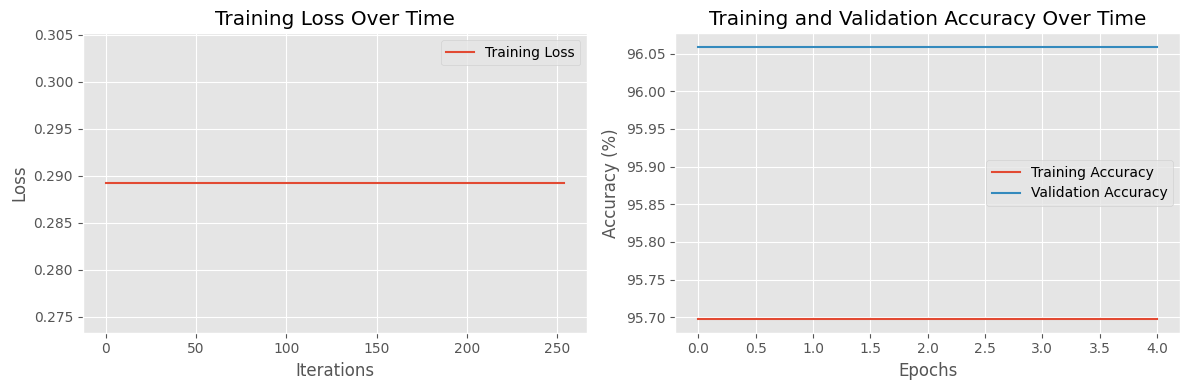

In [ ]:

train_costs = []
train_accuracies = []
valid_accuracies = []

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        if not batch_idx % 50:
            train_costs.append(cost.item())  # cost into List

    model.eval()
    with torch.set_grad_enabled(False):
        train_accuracy = compute_accuracy(model, train_loader)
        valid_accuracy = compute_accuracy(model, valid_loader)
        train_accuracies.append(train_accuracy.item())  # train accuracy into list
        valid_accuracies.append(valid_accuracy.item())  # Validation accuracy into list

    print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

# Plot grafik
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_costs, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation

In [ ]:
model.eval()

with torch.set_grad_enabled(False):
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 95.77%


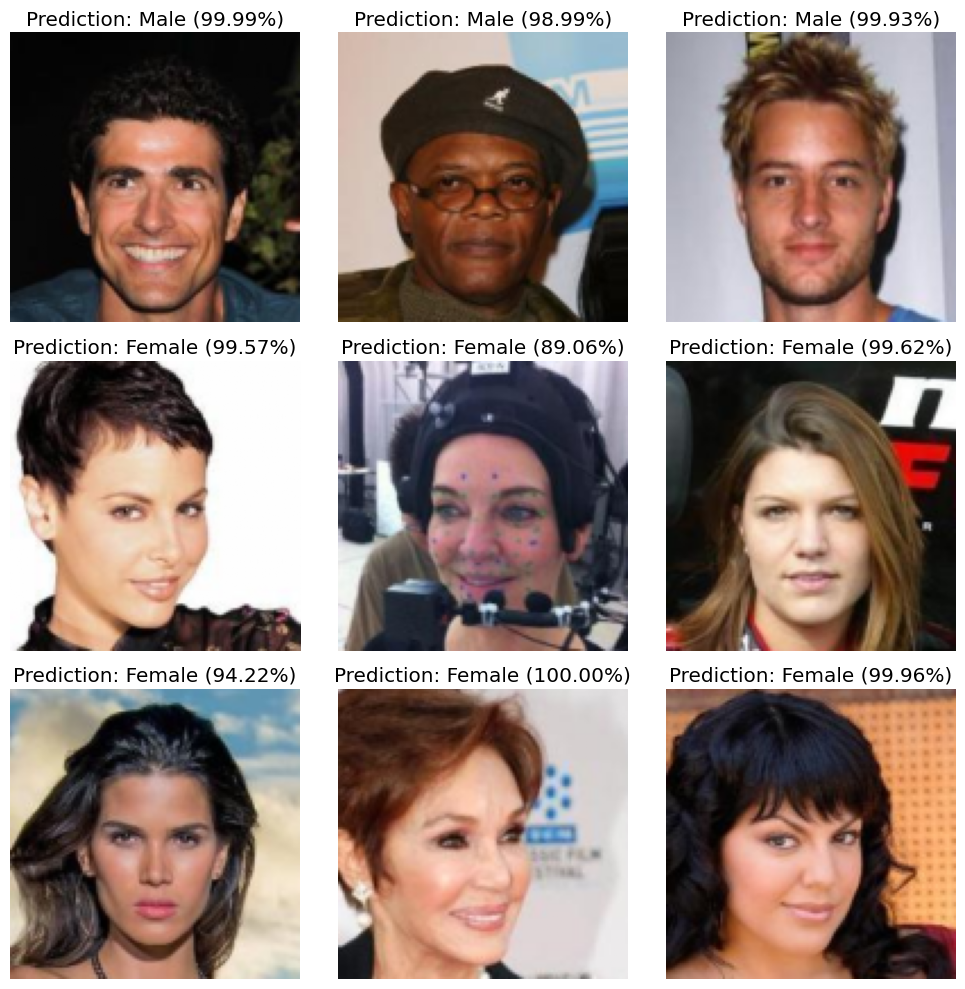

In [ ]:
model.eval()  # Set model in mode evaluasi

# Ambil 9 indeks sampel acak dari data tes
random_indices = random.sample(range(len(test_loader)), 9)

# Membuat tiga baris dengan tiga gambar di setiap baris
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop untuk inferensi dengan data tes
with torch.set_grad_enabled(False):
    for i, idx in enumerate(random_indices):
        row, col = i // 3, i % 3
        ax = axes[row, col]

        features, targets = test_loader.dataset[idx]

        # Lakukan inferensi dengan model
        features = features.unsqueeze(0).to(device)  # Tambahkan dimensi batch
        logits, _ = model(features)
        predicted_label = torch.argmax(logits, dim=1).item()

        # Menampilkan sampel gambar berserta persentase prediksi gendernya
        predicted_class = "Male" if predicted_label == 1 else "Female"
        predicted_proba = torch.softmax(logits[0], dim=0)[predicted_label].item() * 100

        ax.set_title(f"Prediction: {predicted_class} ({predicted_proba:.2f}%)")
        ax.imshow(features[0].cpu().numpy().transpose(1, 2, 0))  # Gambar harus diubah dari format tensor PyTorch ke numpy
        ax.axis('off')

plt.tight_layout()
plt.show()


Save Model

In [ ]:
torch.save(model.state_dict(), 'gender_detection_model.pth')

Deploy on Video

In [ ]:
import torch
import cv2
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi model
model.load_state_dict(torch.load("gender_detection_model.pth"))
model.to(device)
model.eval()

cap = cv2.VideoCapture('vtest.avi')

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?)")
        break

    # Inference
    with torch.no_grad():
        output = model(input_frame)
        _, predicted = output.max(1)

        # Decode the gender prediction (1 for male, 0 for female)
        gender = "Male" if predicted.item() == 1 else "Female"

    # Display the result on the frame
    cv2.putText(frame, gender, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
